In [1]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [18]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

# custom imports
from multiprocessing import Pool        # Multiprocess Runs

warnings.filterwarnings('ignore')

In [19]:
pd.set_option('max_rows', 200)

In [20]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

In [37]:
########################### Helper to load data by store ID
#################################################################################
# Read data
def gen_data_by_store(store):
    
    # Read and contact basic feature
    df = pd.concat([pd.read_pickle(BASE),
                    pd.read_pickle(PRICE).iloc[:,2:],
                    pd.read_pickle(CALENDAR).iloc[:,2:]],
                    axis=1)
    
    # Leave only relevant store
    df = df[df['store_id']==store]

    # With memory limits we have to read 
    # lags and mean encoding features
    # separately and drop items that we don't need.
    # As our Features Grids are aligned 
    # we can use index to keep only necessary rows
    # Alignment is good for us as concat uses less memory than merge.
    df2 = pd.read_pickle(MEAN_ENC)[mean_features]
    df2 = df2[df2.index.isin(df.index)]
    
    df3 = pd.read_pickle(LAGS).iloc[:,3:]
    df3 = df3[df3.index.isin(df.index)]
    
    df = pd.concat([df, df2], axis=1)
    del df2 # to not reach memory limit 
    
    df = pd.concat([df, df3], axis=1)
    del df3 # to not reach memory limit 
    
    # Create features list
    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d',TARGET]+features]
    
    df.to_pickle(f'../cache/notebook_{store}.pkl', compression='gzip')
    return

def get_data_by_store(store, base_path='./', compression=None):
    
    df = pd.read_pickle(f'{base_path}notebook_{store}.pkl', compression=compression)
    
    # Skipping first n rows
    df = df[df['d']>=START_TRAIN].reset_index(drop=True)
    
    features = df.columns.drop(['id','d',TARGET]).tolist()
    
    return df, features

# Recombine Test set after training
def get_base_test(base_path='.'):
    base_test = pd.DataFrame()

    for store_id in STORES_IDS:
        temp_df = pd.read_pickle(f'{base_path}/test_'+store_id+'.pkl')
        temp_df['store_id'] = store_id
        base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)
    
    return base_test


########################### Helper to make dynamic rolling lags
#################################################################################
def make_lag(LAG_DAY):
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'sales_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
    return lag_df[[col_name]]


def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

In [38]:
########################### Model params
#################################################################################
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'regression',#'tweedie','regression',
#                     'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
                } 

# Let's look closer on params

## 'boosting_type': 'gbdt'
# we have 'goss' option for faster training
# but it normally leads to underfit.
# Also there is good 'dart' mode
# but it takes forever to train
# and model performance depends 
# a lot on random factor 
# https://www.kaggle.com/c/home-credit-default-risk/discussion/60921

## 'objective': 'tweedie'
# Tweedie Gradient Boosting for Extremely
# Unbalanced Zero-inflated Data
# https://arxiv.org/pdf/1811.10192.pdf
# and many more articles about tweediie
#
# Strange (for me) but Tweedie is close in results
# to my own ugly loss.
# My advice here - make OWN LOSS function
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/140564
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/143070
# I think many of you already using it (after poisson kernel appeared) 
# (kagglers are very good with "params" testing and tuning).
# Try to figure out why Tweedie works.
# probably it will show you new features options
# or data transformation (Target transformation?).

## 'tweedie_variance_power': 1.1
# default = 1.5
# set this closer to 2 to shift towards a Gamma distribution
# set this closer to 1 to shift towards a Poisson distribution
# my CV shows 1.1 is optimal 
# but you can make your own choice

## 'metric': 'rmse'
# Doesn't mean anything to us
# as competition metric is different
# and we don't use early stoppings here.
# So rmse serves just for general 
# model performance overview.
# Also we use "fake" validation set
# (as it makes part of the training set)
# so even general rmse score doesn't mean anything))
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834

## 'subsample': 0.5
# Serves to fight with overfit
# this will randomly select part of data without resampling
# Chosen by CV (my CV can be wrong!)
# Next kernel will be about CV

##'subsample_freq': 1
# frequency for bagging
# default value - seems ok

## 'learning_rate': 0.03
# Chosen by CV
# Smaller - longer training
# but there is an option to stop 
# in "local minimum"
# Bigger - faster training
# but there is a chance to
# not find "global minimum" minimum

## 'num_leaves': 2**11-1
## 'min_data_in_leaf': 2**12-1
# Force model to use more features
# We need it to reduce "recursive"
# error impact.
# Also it leads to overfit
# that's why we use small 
# 'max_bin': 100

## l1, l2 regularizations
# https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
# Good tiny explanation
# l2 can work with bigger num_leaves
# but my CV doesn't show boost
                    
## 'n_estimators': 1400
# CV shows that there should be
# different values for each state/store.
# Current value was chosen 
# for general purpose.
# As we don't use any early stopings
# careful to not overfit Public LB.

##'feature_fraction': 0.5
# LightGBM will randomly select 
# part of features on each iteration (tree).
# We have maaaany features
# and many of them are "duplicates"
# and many just "noise"
# good values here - 0.5-0.7 (by CV)

## 'boost_from_average': False
# There is some "problem"
# to code boost_from_average for 
# custom loss
# 'True' makes training faster
# BUT carefull use it
# https://github.com/microsoft/LightGBM/issues/1514
# not our case but good to know cons

In [ ]:
########################### Vars
#################################################################################
VER = 1                          # Our model version
SEED = 42                        # We want all things
seed_everything(SEED)            # to be as deterministic 
lgb_params['seed'] = SEED        # as possible
N_CORES = psutil.cpu_count()     # Available CPU cores


#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 28                 # Prediction horizon
USE_AUX     = False               # Use or not pretrained models

#FEATURES to remove
## These features lead to overfit
## or values not present in test set
ROLLING_TEMP_FEATURES= ['rolling_mean_tmp_1_7', 'rolling_mean_tmp_1_30', 'rolling_mean_tmp_14_30', 'rolling_mean_tmp_14_7', 'rolling_mean_tmp_7_30', 'rolling_mean_tmp_7_14', 'rolling_mean_tmp_7_60', 'rolling_mean_tmp_1_14', 'rolling_mean_tmp_14_60', 'rolling_mean_tmp_7_7', 'rolling_mean_tmp_14_14', 'rolling_mean_tmp_1_60']

remove_features = ['id','state_id','store_id',
                   'date','wm_yr_wk','d',TARGET, 'sales_diff', 'no_sales']

mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std',
                  'enc_tm_dw_mean', 'enc_tm_dw_std',
                  'enc_tm_dw_item_id_mean','enc_tm_dw_item_id_std']+['enc_tm_y_mean_sell',
 'enc_tm_y_std_sell',
 'enc_state_id_tm_y_mean_sell',
 'enc_state_id_tm_y_std_sell',
 'enc_store_id_tm_y_mean_sell',
 'enc_store_id_tm_y_std_sell',
 'enc_cat_id_tm_y_mean_sell',
 'enc_cat_id_tm_y_std_sell',
 'enc_dept_id_tm_y_mean_sell',
 'enc_dept_id_tm_y_std_sell',
 'enc_item_id_tm_y_mean_sell',
 'enc_item_id_tm_y_std_sell',
 'enc_item_id_state_id_tm_y_mean_sell',
 'enc_item_id_state_id_tm_y_std_sell',
 'enc_item_id_store_id_tm_y_mean_sell',
 'enc_item_id_store_id_tm_y_std_sell',
 'sales_pca_id7_1',
 'sales_pca_id7_2',
 'sales_pca_id7_3']


#PATHS for Features
ORIGINAL = '../input/m5-forecasting-accuracy/'
BASE     = '../cache/grid_part_1.pkl'
PRICE    = '../cache/grid_part_2.pkl'
CALENDAR = '../cache/grid_part_3.pkl'
LAGS     = '../cache/lags_df_28.pkl'
MEAN_ENC = '../cache/mean_encoding_df.pkl'


# AUX(pretrained) Models paths
# AUX_MODELS = '../input/m5-aux-models/'


#STORES ids
STORES_IDS = pd.read_csv(ORIGINAL+'sales_train_validation.csv')['store_id']
STORES_IDS = list(STORES_IDS.unique())


#SPLITS for lags creation
SHIFT_DAY  = 28
N_LAGS     = 15
LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
ROLS_SPLIT = []
for i in [1,7,14]:
    for j in [7,14,30,60]:
        ROLS_SPLIT.append([i,j])
        
#features
for i in STORES_IDS:
    gen_data_by_store(i)

In [29]:
def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

def permutation_importance(model, validation_df, features_columns, target, metric=rmse, verbose=1):

    list_ = []
    # Make normal prediction with our model and save score
    validation_df['preds'] = model.predict(validation_df[features_columns])
    base_score = metric(validation_df[target], validation_df['preds'])
    if verbose>0:
        print('Standart RMSE', base_score)

    # Now we are looping over all our numerical features
    for col in features_columns:

        # We will make validation set copy to restore
        # features states on each run
        temp_df = validation_df.copy()

        # Error here appears if we have "categorical" features and can't 
        # do np.random.permutation without disrupt categories
        # so we need to check if feature is numerical
        if temp_df[col].dtypes.name != 'category':
            temp_df[col] = np.random.permutation(temp_df[col].values)
            temp_df['preds'] = model.predict(temp_df[features_columns])
            cur_score = metric(temp_df[target], temp_df['preds'])
            
            list_.append({'feature':col, 'permutation_importance':np.round(cur_score - base_score, 4)})
            # If our current rmse score is less than base score
            # it means that feature most probably is a bad one
            # and our model is learning on noise
            if verbose>0:
                print(col, np.round(cur_score - base_score, 4))
            
    return pd.DataFrame(list_).sort_values(by=['permutation_importance'], ascending=False)


# permutation_importance_df = permutation_importance(estimator, valid_df, features_columns, TARGET, metric=rmse, verbose=1)

In [9]:
########################### Aux Models
# If you don't want to wait hours and hours
# to have result you can train each store 
# in separate kernel and then just join result.

# If we want to use pretrained models we can 
## skip training 
## (in our case do dummy training
##  to show that we are good with memory
##  and you can safely use this (all kernel) code)
if USE_AUX:
    lgb_params['n_estimators'] = 2
    
# Here is some 'logs' that can compare
#Train CA_1
#[100]	valid_0's rmse: 2.02289
#[200]	valid_0's rmse: 2.0017
#[300]	valid_0's rmse: 1.99239
#[400]	valid_0's rmse: 1.98471
#[500]	valid_0's rmse: 1.97923
#[600]	valid_0's rmse: 1.97284
#[700]	valid_0's rmse: 1.96763
#[800]	valid_0's rmse: 1.9624
#[900]	valid_0's rmse: 1.95673
#[1000]	valid_0's rmse: 1.95201
#[1100]	valid_0's rmse: 1.9476
#[1200]	valid_0's rmse: 1.9434
#[1300]	valid_0's rmse: 1.9392
#[1400]	valid_0's rmse: 1.93446

#Train CA_2
#[100]	valid_0's rmse: 1.88949
#[200]	valid_0's rmse: 1.84767
#[300]	valid_0's rmse: 1.83653
#[400]	valid_0's rmse: 1.82909
#[500]	valid_0's rmse: 1.82265
#[600]	valid_0's rmse: 1.81725
#[700]	valid_0's rmse: 1.81252
#[800]	valid_0's rmse: 1.80736
#[900]	valid_0's rmse: 1.80242
#[1000]	valid_0's rmse: 1.79821
#[1100]	valid_0's rmse: 1.794
#[1200]	valid_0's rmse: 1.78973
#[1300]	valid_0's rmse: 1.78552
#[1400]	valid_0's rmse: 1.78158

In [33]:
########################### Train Models
#################################################################################
his = []
do_permutation = True
try_1_store = True
if not USE_AUX:
    for store_id in STORES_IDS:
        print('Train', store_id)

        # Get grid for current store
        grid_df, features_columns = get_data_by_store(store_id, base_path='../cache/')

        # Masks for 
        # Train (All data less than 1913)
        # "Validation" (Last 28 days - not real validatio set)
        # Test (All data greater than 1913 day, 
        #       with some gap for recursive features)
        train_mask = grid_df['d']<=(END_TRAIN)
        valid_mask = train_mask&(grid_df['d']>(END_TRAIN-P_HORIZON))
        preds_mask = grid_df['d']>(END_TRAIN-100)

        # Apply masks and save lgb dataset as bin
        # to reduce memory spikes during dtype convertations
        # https://github.com/Microsoft/LightGBM/issues/1032
        # "To avoid any conversions, you should always use np.float32"
        # or save to bin before start training
        # https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
        train_data = lgb.Dataset(grid_df[train_mask][features_columns], 
                           label=grid_df[train_mask][TARGET])
#         train_data.save_binary('train_data.bin')
#         train_data = lgb.Dataset('train_data.bin')

        valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
                           label=grid_df[valid_mask][TARGET])

        # Launch seeder again to make lgb training 100% deterministic
        # with each "code line" np.random "evolves" 
        # so we need (may want) to "reset" it
        seed_everything(SEED)
        estimator = lgb.train(lgb_params,
                              train_data,
                              valid_sets = [valid_data],
                              verbose_eval = 100,
                              )
        if do_permutation:
            permutation_importance_df = permutation_importance(estimator, grid_df[valid_mask], features_columns, TARGET, metric=rmse, verbose=0)
        else:
            permutation_importance_df = None
        
        
        
        his.append({'store_id':store_id, 'permutation_importance_df':permutation_importance_df,})
        if try_1_store:
            break
        
        # Saving part of the dataset for later predictions
        # Removing features that we need to calculate recursively 
        grid_df = grid_df[preds_mask].reset_index(drop=True)
        keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
        grid_df = grid_df[keep_cols]
        grid_df.to_pickle('test_'+store_id+'.pkl')

        # Save model - it's not real '.bin' but a pickle file
        # estimator = lgb.Booster(model_file='model.txt')
        # can only predict with the best iteration (or the saving iteration)
        # pickle.dump gives us more flexibility
        # like estimator.predict(TEST, num_iteration=100)
        # num_iteration - number of iteration want to predict with, 
        # NULL or <= 0 means use best iteration
        model_name = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin'
        pickle.dump(estimator, open(model_name, 'wb'))

        # Remove temporary files and objects 
        # to free some hdd space and ram memory
        # !rm train_data.bin
        del train_data, valid_data, estimator, grid_df
        gc.collect()

        # "Keep" models features for predictions
        MODEL_FEATURES = features_columns
        
else:
    _, MODEL_FEATURES = get_data_by_store(STORES_IDS[0])

Train CA_1
[100]	valid_0's rmse: 1.38797
[200]	valid_0's rmse: 1.29097
[300]	valid_0's rmse: 1.29047
[400]	valid_0's rmse: 1.29367
[500]	valid_0's rmse: 1.29527
[600]	valid_0's rmse: 1.29226
[700]	valid_0's rmse: 1.28961
[800]	valid_0's rmse: 1.28808
[900]	valid_0's rmse: 1.28369
[1000]	valid_0's rmse: 1.2812
[1100]	valid_0's rmse: 1.2778
[1200]	valid_0's rmse: 1.27536
[1300]	valid_0's rmse: 1.27197
[1400]	valid_0's rmse: 1.26662


In [35]:
permutation_importance_df.head(20)

,feature,permutation_importance
49,sales_diff,1.3694
91,rolling_mean_tmp_1_7,0.8580
50,no_sales,0.5089
48,sales_pca_id7_3,0.3134
47,sales_pca_id7_2,0.3091
92,rolling_mean_tmp_1_14,0.1684
93,rolling_mean_tmp_1_30,0.0716
94,rolling_mean_tmp_1_60,0.0217
68,sum_latest7_sales,0.0135
18,tm_dw,0.0134


In [94]:
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = estimator.feature_name()
feature_importance_df['importance'] = estimator.feature_importance()
feature_importance_df.sort_values(by=['importance'], ascending=False, inplace=True)
feature_importance_df.reset_index(drop=True, inplace=True)

# feature_importance_df = pd.DataFrame()
# for store_id in STORES_IDS:
#     model_name = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin'
#     estimator = pickle.load(open(model_name, 'rb'))
#     feature_importance_df[store_id] = estimator.feature_importance()
# feature_importance_df['feature'] = estimator.feature_name()
# feature_importance_df['importance_mean'] = feature_importance_df.drop(columns=['feature']).mean(axis=1)
# feature_importance_df.sort_values(by=['importance_mean'], ascending=False, inplace=True)
# feature_importance_df.reset_index(drop=True, inplace=True)
# # lgb.plot_importance(estimator, max_num_features=20)

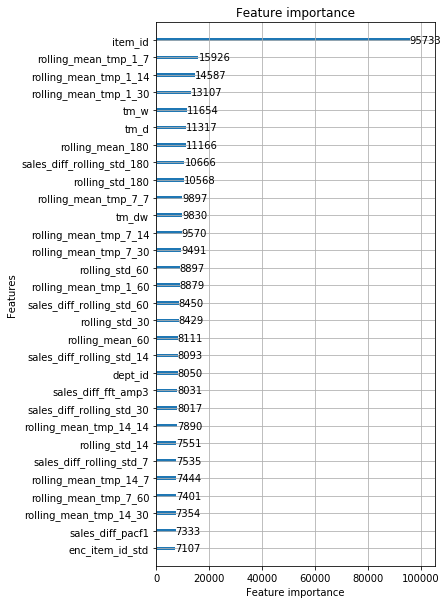

In [26]:
Train CA_1
[100]	valid_0's rmse: 2.05355
[200]	valid_0's rmse: 2.05005
[300]	valid_0's rmse: 2.05159
[400]	valid_0's rmse: 2.05153
[500]	valid_0's rmse: 2.05033
[600]	valid_0's rmse: 2.04557
[700]	valid_0's rmse: 2.03879
[800]	valid_0's rmse: 2.03395
[900]	valid_0's rmse: 2.02572
[1000]	valid_0's rmse: 2.01963
[1100]	valid_0's rmse: 2.01417
[1200]	valid_0's rmse: 2.00851
[1300]	valid_0's rmse: 2.00469
[1400]	valid_0's rmse: 1.99971

In [139]:
permutation_importance_df = his[0]['permutation_importance_df'].rename(columns={'permutation_importance':'permutation_importance1'})
for idx, item in enumerate(his[1:]):
    permutation_importance_df = pd.merge(permutation_importance_df, item['permutation_importance_df'].rename(columns={'permutation_importance':f'permutation_importance{idx+2}'}), on='feature', how='left',)
permutation_importance_df['permutation_importance'] = permutation_importance_df.drop(columns=['feature']).mean(axis=1)
permutation_importance_df.sort_values(by=['permutation_importance'], ascending=False, inplace=True)
permutation_importance_df = permutation_importance_df[['feature','permutation_importance']+[f'permutation_importance{i}' for i in range(1, 11)]]

In [140]:
permutation_importance_df

,feature,permutation_importance,permutation_importance1,permutation_importance2,permutation_importance3,permutation_importance4,permutation_importance5,permutation_importance6,permutation_importance7,permutation_importance8,permutation_importance9,permutation_importance10
0,rolling_mean_tmp_1_7,0.91387,0.8179,0.6102,1.4656,0.2022,0.9141,0.9704,0.8684,0.4756,1.4629,1.3514
1,rolling_mean_tmp_1_14,0.38904,0.3695,0.3854,0.6054,0.1556,0.3393,0.3260,0.3957,0.2815,0.6162,0.4158
2,rolling_mean_tmp_7_7,0.06319,0.0643,0.0340,0.1336,0.0121,0.0347,0.0707,0.0680,0.0375,0.0988,0.0782
3,tm_dw,0.02659,0.0283,0.0366,0.0350,0.0062,0.0235,0.0321,0.0163,0.0284,0.0120,0.0475
7,rolling_mean_tmp_1_30,0.01717,0.0069,0.0214,0.0160,0.0060,0.0106,0.0018,0.0109,0.0082,0.0677,0.0222
4,enc_tm_dw_item_id_mean,0.01472,0.0151,0.0132,0.0211,0.0083,0.0109,0.0222,0.0165,0.0078,0.0078,0.0243
5,rolling_mean_tmp_7_14,0.01405,0.0139,0.0129,0.0267,0.0042,0.0092,0.0178,0.0146,0.0108,0.0153,0.0151
6,enc_tm_dw_mean,0.00798,0.0070,0.0109,0.0073,0.0019,0.0041,0.0116,0.0042,0.0130,0.0057,0.0141
9,rolling_mean_tmp_7_30,0.00684,0.0061,0.0060,0.0066,0.0040,0.0059,0.0071,0.0064,0.0052,0.0129,0.0082
11,tm_d,0.00553,0.0043,0.0023,0.0039,0.0011,0.0014,0.0022,0.0029,0.0024,0.0258,0.0090


In [ ]:
from sklearn.decomposition import PCA

def make_pca(df, pca_col, n_days):
    print('PCA:', pca_col, n_days)
    
    # We don't need any other columns to make pca
    pca_df = df[[pca_col,'d',TARGET]]
    
    # If we are doing pca for other series "levels" 
    # we need to agg first
    if pca_col != 'id':
        merge_base = pca_df[[pca_col,'d']]
        pca_df = pca_df.groupby([pca_col,'d'])[TARGET].agg(['sum']).reset_index()
        pca_df[TARGET] = pca_df['sum']
        del pca_df['sum']
    
    # Min/Max scaling
    pca_df[TARGET] = pca_df[TARGET]/pca_df[TARGET].max()
    
    # Making "lag" in old way (not parallel)
    LAG_DAYS = [col for col in range(1,n_days+1)]
    format_s = '{}_pca_'+pca_col+str(n_days)+'_{}'
    pca_df = pca_df.assign(**{
            format_s.format(col, l): pca_df.groupby([pca_col])[col].transform(lambda x: x.shift(l))
            for l in LAG_DAYS
            for col in [TARGET]
        })
    
    pca_columns = list(pca_df)[3:]
    
    pca_df[pca_columns] = pca_df[pca_columns].fillna(-999999)
    pca = PCA(random_state=SEED)
    
    # You can use fit_transform here
    
    pca.fit(pca_df[pca_columns])
    pca_df[pca_columns] = pca.transform(pca_df[pca_columns])
    
    print(pca.explained_variance_ratio_)
    
    # we will keep only 3 most "valuable" columns/dimensions 
    keep_cols = pca_columns[:3]
    print('Columns to keep:', keep_cols)
    
    # If we are doing pca for other series "levels"
    # we need merge back our results to merge_base df
    # and only than return resulted df
    # I'll skip that step here
    
    return pca_df[keep_cols]




In [101]:
########################### Predict
#################################################################################

# Create Dummy DataFrame to store predictions
all_preds = pd.DataFrame()

# Join back the Test dataset with 
# a small part of the training data 
# to make recursive features
base_test = get_base_test()

# Timer to measure predictions time 
main_time = time.time()

# Loop over each prediction day
# As rolling lags are the most timeconsuming
# we will calculate it for whole day
for PREDICT_DAY in range(1,29):    
    print('Predict | Day:', PREDICT_DAY)
    start_time = time.time()

    # Make temporary grid to calculate rolling lags
    grid_df = base_test.copy()
    grid_df = pd.concat([grid_df, df_parallelize_run(make_lag_roll, ROLS_SPLIT)], axis=1)
    # Make PCA
    grid_df = pd.concat([grid_df, make_pca(grid_df,'id',7)], axis=1)
    
        
    for store_id in STORES_IDS:
        
        # Read all our models and make predictions
        # for each day/store pairs
        model_path = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin' 
        USE_AUX = False
        if USE_AUX:
            model_path = AUX_MODELS + model_path
        
        estimator = pickle.load(open(model_path, 'rb'))
        
        day_mask = base_test['d']==(END_TRAIN+PREDICT_DAY)
        store_mask = base_test['store_id']==store_id
        
        mask = (day_mask)&(store_mask)
        base_test[TARGET][mask] = estimator.predict(grid_df[mask][MODEL_FEATURES])
    
    # Make good column naming and add 
    # to all_preds DataFrame
    temp_df = base_test[day_mask][['id',TARGET]]
    temp_df.columns = ['id','F'+str(PREDICT_DAY)]
    if 'id' in list(all_preds):
        all_preds = all_preds.merge(temp_df, on=['id'], how='left')
    else:
        all_preds = temp_df.copy()
        
    print('#'*10, ' %0.2f min round |' % ((time.time() - start_time) / 60),
                  ' %0.2f min total |' % ((time.time() - main_time) / 60),
                  ' %0.2f day sales |' % (temp_df['F'+str(PREDICT_DAY)].sum()))
    del temp_df
    
all_preds = all_preds.reset_index(drop=True)
all_preds

Predict | Day: 1
##########  0.40 min round |  0.40 min total |  37017.23 day sales |
Predict | Day: 2
##########  0.39 min round |  0.79 min total |  34847.97 day sales |
Predict | Day: 3
##########  0.39 min round |  1.18 min total |  34410.46 day sales |
Predict | Day: 4
##########  0.39 min round |  1.57 min total |  34847.52 day sales |
Predict | Day: 5
##########  0.40 min round |  1.97 min total |  40452.51 day sales |
Predict | Day: 6
##########  0.39 min round |  2.36 min total |  49418.73 day sales |
Predict | Day: 7
##########  0.39 min round |  2.75 min total |  53106.42 day sales |
Predict | Day: 8
##########  0.40 min round |  3.15 min total |  44475.07 day sales |
Predict | Day: 9
##########  0.39 min round |  3.54 min total |  43574.40 day sales |
Predict | Day: 10
##########  0.39 min round |  3.93 min total |  38899.64 day sales |
Predict | Day: 11
##########  0.39 min round |  4.33 min total |  40427.91 day sales |
Predict | Day: 12
##########  0.39 min round |  4.72

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.781191,0.737819,0.693788,0.670643,0.931213,1.045179,1.131295,0.977368,1.029436,...,0.853931,1.071140,1.012690,0.813684,0.837206,0.776901,0.739296,0.994093,1.058626,1.011238
1,HOBBIES_1_002_CA_1_validation,0.146719,0.160543,0.164092,0.162682,0.202359,0.270320,0.315719,0.248348,0.241531,...,0.196759,0.259468,0.246624,0.169012,0.173103,0.173452,0.197364,0.208930,0.251847,0.250947
2,HOBBIES_1_003_CA_1_validation,0.550704,0.490335,0.493414,0.532273,0.628262,0.771446,0.726727,0.585654,0.576871,...,0.598278,0.702515,0.721026,0.549122,0.525873,0.547755,0.564779,0.652027,0.689392,0.656422
3,HOBBIES_1_004_CA_1_validation,1.735303,1.339274,1.279435,1.447430,1.853449,2.891171,3.212673,1.865653,1.496920,...,1.773265,2.837330,3.426651,2.000002,1.496414,1.297739,1.404536,1.862203,3.100143,3.420127
4,HOBBIES_1_005_CA_1_validation,0.962112,0.896366,0.887831,0.947995,1.045938,1.611036,1.631309,0.972528,0.956437,...,1.051034,1.568430,1.608332,1.002504,0.891765,0.901244,0.852647,1.009962,1.474109,1.416456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0.313053,0.299497,0.298417,0.276051,0.314564,0.363590,0.427211,0.444330,0.482609,...,0.443408,0.527926,0.634457,0.416124,0.361947,0.343189,0.302200,0.319124,0.415056,0.505594
30486,FOODS_3_824_WI_3_validation,0.277690,0.247147,0.230371,0.229777,0.242099,0.278417,0.305717,0.352961,0.279749,...,0.286933,0.374302,0.402373,0.286608,0.236044,0.232470,0.198073,0.200154,0.265566,0.254415
30487,FOODS_3_825_WI_3_validation,0.677644,0.558143,0.492277,0.565036,0.586838,0.733219,0.929167,1.046266,1.068431,...,1.122828,1.372197,1.507528,1.024560,0.855999,0.749650,0.666131,0.728410,0.931452,1.019991
30488,FOODS_3_826_WI_3_validation,0.904145,0.870684,0.824765,0.771901,0.880479,1.158155,1.036926,1.130491,1.177652,...,0.961502,1.291709,1.328578,0.893950,0.895090,0.822411,0.847574,0.891789,1.038828,1.082830


In [105]:
########################### Export
#################################################################################
# Reading competition sample submission and
# merging our predictions
# As we have predictions only for "_validation" data
# we need to do fillna() for "_evaluation" items
submission = pd.read_csv(ORIGINAL+'sample_submission.csv')[['id']]
submission = submission.merge(all_preds, on=['id'], how='left').fillna(0)
submission.to_csv('submission_v'+str(VER)+'.csv', index=False)

In [10]:
# Summary

# Of course here is no magic at all.
# No "Novel" features and no brilliant ideas.
# We just carefully joined all
# our previous fe work and created a model.

# Also!
# In my opinion this strategy is a "dead end".
# Overfits a lot LB and with 1 final submission 
# you have no option to risk.


# Improvement should come from:
# Loss function
# Data representation
# Stable CV
# Good features reduction strategy
# Predictions stabilization with NN
# Trend prediction
# Real zero sales detection/classification


# Good kernels references 
## (the order is random and the list is not complete):
# https://www.kaggle.com/ragnar123/simple-lgbm-groupkfold-cv
# https://www.kaggle.com/jpmiller/grouping-items-by-stockout-pattern
# https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda
# https://www.kaggle.com/sibmike/m5-out-of-stock-feature
# https://www.kaggle.com/mayer79/m5-forecast-attack-of-the-data-table
# https://www.kaggle.com/yassinealouini/seq2seq
# https://www.kaggle.com/kailex/m5-forecaster-v2
# https://www.kaggle.com/aerdem4/m5-lofo-importance-on-gpu-via-rapids-xgboost


# Features were created in these kernels:
## 
# Mean encodings and PCA options
# https://www.kaggle.com/kyakovlev/m5-custom-features
##
# Lags and rolling lags
# https://www.kaggle.com/kyakovlev/m5-lags-features
##
# Base Grid and base features (calendar/price/etc)
# https://www.kaggle.com/kyakovlev/m5-simple-fe


# Personal request
# Please don't upvote any ensemble and copypaste kernels
## The worst case is ensemble without any analyse.
## The best choice - just ignore it.
## I would like to see more kernels with interesting and original approaches.
## Don't feed copypasters with upvotes.

## It doesn't mean that you should not fork and improve others kernels
## but I would like to see params and code tuning based on some CV and analyse
## and not only on LB probing.
## Small changes could be shared in comments and authors can improve their kernel.

## Feel free to criticize this kernel as my knowlege is very limited
## and I can be wrong in code and descriptions. 
## Thank you.